# PTA and Astrometry Cross-correlation (MAPS)

The maps in this notebook are reproduced with **numerical integration**, the functions for this calculations are defined in **response.py**

In [1]:
import numpy as np
import healpy as hp
import itertools
import jax.numpy as jnp
from jax import vmap, grad
from response import pulsar_star_pair_monopole, pulsar_star_pair_dipole, vvec, Sq_pair_pair_K0, Sq_pair_pair_K1
from jax import config
# config.update("jax_enable_x64", True)

# plot settings
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

font = {'size': 12, 'family':'Serif'}
#font = {'size': 18, 'family':'Latin Modern Roman'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Monopole visualisation

Map for $K_{i}^{(0)}$ defined in the equation (2.21) from 2412.14010. 

We consider:
* $\bf p$ the direction of the GW propagation,
* $\bf q$ the positions of the stars as the position of each of the pixels of the map. You will see in the code an array defined as **stars_vec** that contains all these vectors and,
* $\bf{n} =(0 ,0)$.

In [2]:
## This part is doing test with the functions to be able to plot them as a scalar function afterwards

get_vec = lambda theta,phi: jnp.array([jnp.sin(theta)*jnp.cos(phi),jnp.sin(theta)*jnp.sin(phi),jnp.cos(theta)])

pi_3 = np.pi/3
pi_4 = np.pi/4
n1 = get_vec(pi_3,pi_3)
n2 = get_vec(pi_4,pi_4)

nside = 16
npix = hp.nside2npix(nside)
pix = np.arange(npix)
print(n1.shape,pix.shape)

pvec_array = np.array(hp.pix2vec(nside,pix)).T

print(np.shape(pvec_array))

monopole = pulsar_star_pair_monopole(n1,n2,pvec_array,nside)

print(monopole.shape)

print(monopole)

#print(jnp.trace(monopole))
print(monopole@(monopole.T))

print(np.array([-0.6444392,  1.4826843, -1.6659255])@(np.array([-0.6444392,  1.4826843, -1.6659255]).T))


(3,) (3072,)
(3072, 3)
(3,)
[-0.6436319  1.4792416 -1.6614608]
5.3628693
5.38896238751338


In [3]:
nside_stars = 8
nstars = hp.nside2npix(nside_stars)
stars_idx = np.arange(nstars)

theta, phi = (np.pi/2,0)
n1 = get_vec(theta,phi)

stars_vec = np.array(hp.pix2vec(nside_stars,stars_idx)).T

print(stars_vec.shape)

# K0*K0^T

f = lambda q: Sq_pair_pair_K0(n1,q,pvec_array,nside)
map_stars_H0H0 = vmap(f)(stars_vec)

print(map_stars_H0H0.shape)


(768, 3)
(768,)


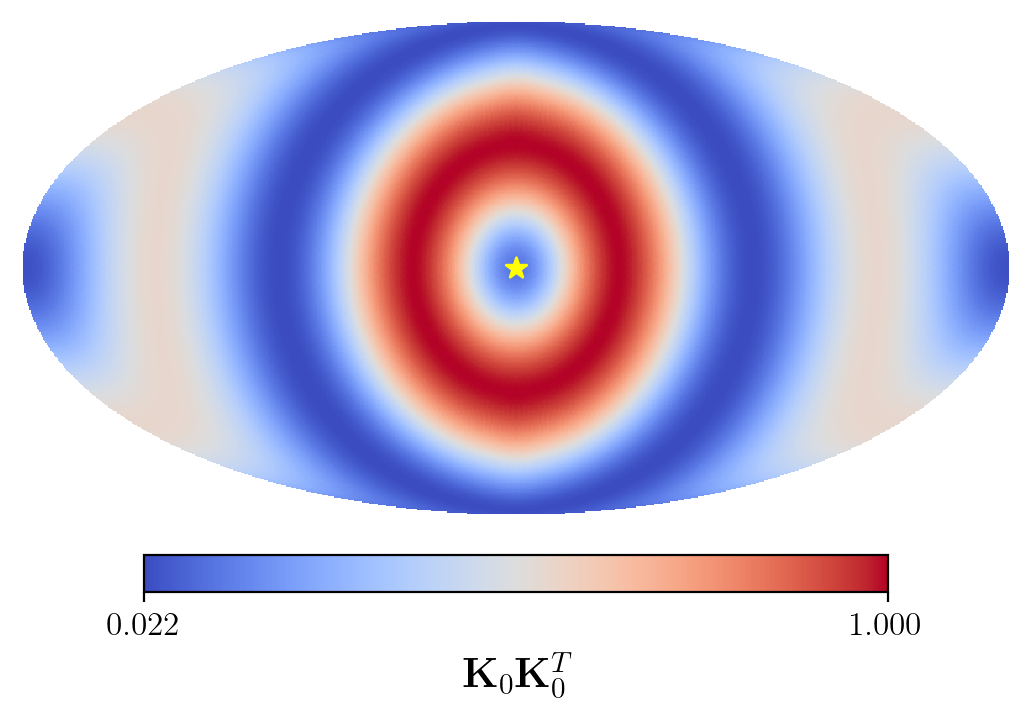

In [4]:
cmap = 'coolwarm'#'RdBu_r'

fwhm = 0.2

# K0*K0^T
sm = map_stars_H0H0
up_map = hp.ud_grade(map_stars_H0H0,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)
min = np.min(sm)
max = np.max(sm)
#plt.axes(ax1)
hp.mollview(sm/max,cmap=cmap,cbar=False,title="",hold=True)
hp.projscatter(theta,phi,marker='*',color='yellow',s=60)
f = plt.gcf()

ax = plt.gca()
image = ax.get_images()[0]
cbar = f.colorbar(image, ax=ax,location='bottom',shrink=0.75 ,ticks=[min/max,1]
                   ,pad=0.05) #0.1
cbar.ax.tick_params(labelsize=12) 
cbar.set_label(label=r'$\mathbf{K}_{0} \mathbf{K}_{0}^{T}$',size=15)

#plt.savefig('K0K0_monopole.pdf',bbox_inches='tight')

# Dipole visualisation
We consider:
* $\bf{v} = (l,b)= (264^{\circ},48^{\circ})$. The file **response.py** contains this direction as **vvec**.
* $\bf{n} = (l,b)=(0^{\circ},0^{\circ})$ for the first case, and $\bf{n}=v$ for the second.
* $\bf q$ is the direction of stars in each of the pixels defined on the map. Is called **stars_vec** in the code.

Coordinate of n1: [270.21936] [-75.456116]
(768, 3)
(768,)


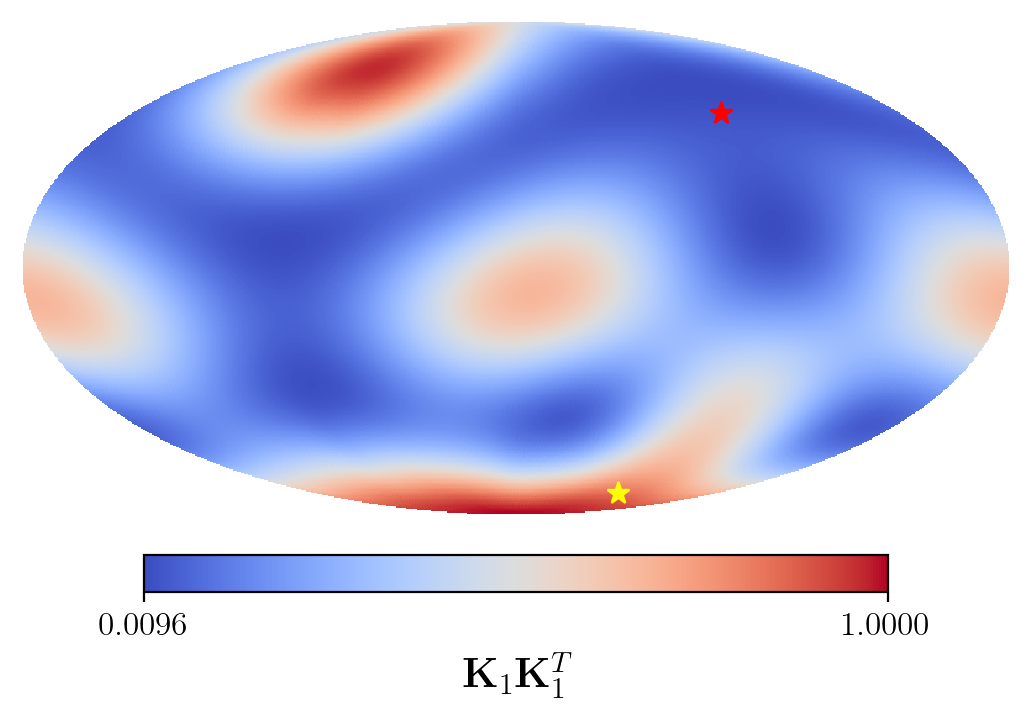

In [5]:
nside_stars = 8
nstars = hp.nside2npix(nside_stars)
stars_idx = np.arange(nstars)

thetaVvec, phiVvec = hp.vec2ang(vvec)

theta, phi = (np.pi/2,0)
#n2 = get_vec(theta,phi) # Star at the centre of the Sky.
#n2 = jnp.array([0.96388439, -0.26566278, 0.01871302]) # Random position in the Sky (close to the centre)
n2 = jnp.array([9.61440915e-04, -2.51119328e-01, -9.67955659e-01]) # Random position in the Sky (south pole)
#n2= jnp.array([-0.18639486, -0.72313051, -0.66508587]) # Orthogonal to V
#n2 = -vvec # Opposite to V
#n2=
theta_n2, phi_n2 = hp.vec2ang(n2)


l, b = hp.vec2ang(n2, lonlat=True)
print('Coordinate of n1:', l, b)

stars_vec = np.array(hp.pix2vec(nside_stars,stars_idx)).T

print(stars_vec.shape)

# The position of the star n2 is fixed at the centre of the map.

#f = lambda q: jnp.trace(pairwise_dipole(n1,q,pvec_array,nside))
f = lambda q: Sq_pair_pair_K1(n2,q,pvec_array,nside)
map_stars_K1K1 = vmap(f)(stars_vec)
print(map_stars_K1K1.shape)


# delta_ij H_ij center
sm = map_stars_K1K1
up_map = hp.ud_grade(map_stars_K1K1,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)
min = np.min(sm)
max = np.max(sm)

hp.mollview(sm/max,cmap=cmap,cbar=False,title="",hold=True)
hp.projscatter(theta_n2, phi_n2,color='yellow',s=60, marker='*')
hp.projscatter(thetaVvec, phiVvec,color='red',s=60, marker='*')
#hp.graticule()
f = plt.gcf()

ax = plt.gca()
image = ax.get_images()[0]
cbar = f.colorbar(image, ax=ax,location='bottom',shrink=0.75 ,ticks=[min/max,1]
                   ,pad=0.05) #0.1
cbar.ax.tick_params(labelsize=12) 
cbar.set_label(label=r'$\mathbf{K}_{1} \mathbf{K}_{1}^{T}$',size=15)

#plt.savefig('K1K1_dipole_Random.pdf',bbox_inches='tight')
